<a href="https://colab.research.google.com/github/kashishthakur26/Tensorflow-learning/blob/main/transfer_learning_up_scaling_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jun  3 08:19:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-03 08:19:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-03 08:19:04 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-06-03 08:19:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  66.5MB/s    in 16s     

2023-06-03 08:19:29 (95.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 director

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [7]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3),name="input_layer")
x = data_augmentation(inputs)
x = base_model(x , training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs , outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 112s 409ms/step - loss: 3.3765 - accuracy: 0.2717 - val_loss: 2.4915 - val_accuracy: 0.4513
Epoch 2/5
237/237 [==============================] - 75s 313ms/step - loss: 2.1960 - accuracy: 0.4981 - val_loss: 2.0222 - val_accuracy: 0.5103
Epoch 3/5
237/237 [==============================] - 65s 270ms/step - loss: 1.8204 - accuracy: 0.5632 - val_loss: 1.8565 - val_accuracy: 0.5373
Epoch 4/5
237/237 [==============================] - 60s 252ms/step - loss: 1.5969 - accuracy: 0.6125 - val_loss: 1.7784 - val_accuracy: 0.5421
Epoch 5/5
237/237 [==============================] - 54s 225ms/step - loss: 1.4435 - accuracy: 0.6504 - val_loss: 1.7258 - val_accuracy: 0.5501


In [12]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

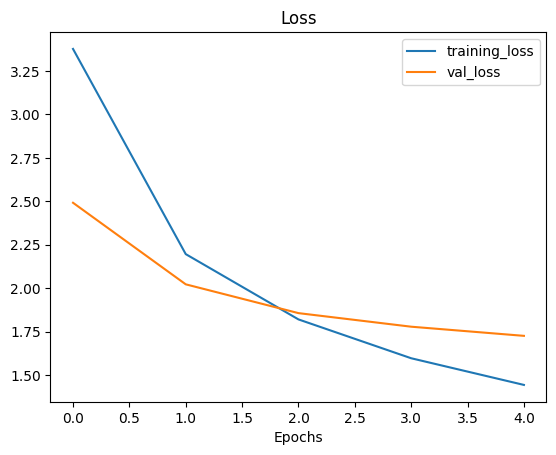

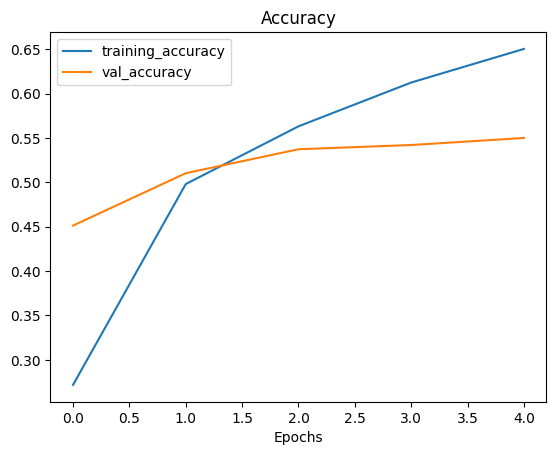

In [13]:
plot_loss_curves(history_all_classes_10_percent)

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [16]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [17]:
fine_tune_epochs = 10 

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 65s 234ms/step - loss: 1.2121 - accuracy: 0.6821 - val_loss: 1.7019 - val_accuracy: 0.5463
Epoch 6/10
237/237 [==============================] - 49s 205ms/step - loss: 1.0866 - accuracy: 0.7123 - val_loss: 1.6802 - val_accuracy: 0.5609
Epoch 7/10
237/237 [==============================] - 46s 193ms/step - loss: 1.0090 - accuracy: 0.7298 - val_loss: 1.6665 - val_accuracy: 0.5612
Epoch 8/10
237/237 [==============================] - 43s 181ms/step - loss: 0.9509 - accuracy: 0.7393 - val_loss: 1.6902 - val_accuracy: 0.5546
Epoch 9/10
237/237 [==============================] - 42s 177ms/step - loss: 0.8737 - accuracy: 0.7678 - val_loss: 1.6630 - val_accuracy: 0.5585
Epoch 10/10
237/237 [==============================] - 48s 199ms/step - loss: 0.8282 - accuracy: 0.7799 - val_loss: 1.6634 - val_accuracy: 0.5583


In [18]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 66s 84ms/step - loss: 1.5060 - accuracy: 0.6017


[1.5060337781906128, 0.60166335105896]

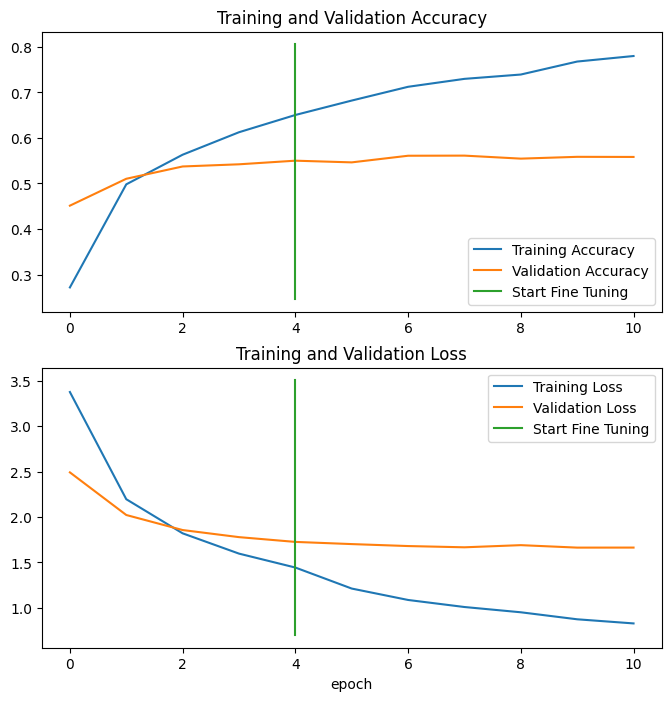

In [19]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere.

In [20]:
# !mkdir -p saved_model
# # model.save('saved_model/my_model')

## Evaluating the performance of the big dog model across all different classes
let's make some predictions, visualize them and then later find out which predictions were the most wrong. 

In [21]:
## Making predictions with our trained model
pred_probs = model.predict(test_data , verbose=1)

790/790 [==============================] - 65s 81ms/step


In [22]:
pred_probs.shape

(25250, 101)

In [23]:
pred_probs[0] , len(pred_probs[0]) , sum(pred_probs[0])

(array([1.45288751e-01, 6.20115898e-04, 1.13246582e-01, 2.40958371e-07,
        1.29459431e-05, 6.01377724e-06, 1.21795783e-04, 9.19285594e-06,
        3.96560691e-02, 3.22845095e-04, 3.37285724e-06, 4.27187206e-06,
        5.50215482e-04, 5.06132437e-07, 1.81962771e-03, 1.90834340e-03,
        3.68744259e-05, 1.97063759e-03, 7.42843980e-03, 6.01954125e-05,
        1.70028536e-03, 5.38775475e-06, 6.90382512e-05, 7.51859843e-05,
        2.99618742e-03, 2.38495856e-03, 1.87045312e-03, 3.78446821e-05,
        1.91825241e-01, 8.90510797e-04, 8.50253764e-06, 2.52409466e-03,
        1.28728570e-03, 1.43213742e-06, 1.64182149e-02, 5.97753751e-06,
        1.39244599e-04, 2.86677713e-03, 1.22989744e-01, 4.62519492e-05,
        1.68521563e-03, 2.78495587e-02, 6.10092655e-04, 3.96524156e-05,
        1.52984532e-04, 4.60689880e-05, 6.03427039e-03, 1.43095458e-04,
        3.68808037e-06, 4.69406806e-02, 2.76796578e-04, 1.56586175e-04,
        3.46037187e-02, 1.42661892e-02, 4.50121042e-05, 9.952890

In [24]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[1000].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.45288751e-01 6.20115898e-04 1.13246582e-01 2.40958371e-07
 1.29459431e-05 6.01377724e-06 1.21795783e-04 9.19285594e-06
 3.96560691e-02 3.22845095e-04 3.37285724e-06 4.27187206e-06
 5.50215482e-04 5.06132437e-07 1.81962771e-03 1.90834340e-03
 3.68744259e-05 1.97063759e-03 7.42843980e-03 6.01954125e-05
 1.70028536e-03 5.38775475e-06 6.90382512e-05 7.51859843e-05
 2.99618742e-03 2.38495856e-03 1.87045312e-03 3.78446821e-05
 1.91825241e-01 8.90510797e-04 8.50253764e-06 2.52409466e-03
 1.28728570e-03 1.43213742e-06 1.64182149e-02 5.97753751e-06
 1.39244599e-04 2.86677713e-03 1.22989744e-01 4.62519492e-05
 1.68521563e-03 2.78495587e-02 6.10092655e-04 3.96524156e-05
 1.52984532e-04 4.60689880e-05 6.03427039e-03 1.43095458e-04
 3.68808037e-06 4.69406806e-02 2.76796578e-04 1.56586175e-04
 3.46037187e-02 1.42661892e-02 4.50121042e-05 9.95289069e-03
 2.12181993e-02 1.07119954e-03 3.20540927e-

In [25]:
test_data.class_names[99]

'tuna_tartare'

In [26]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:100]

array([ 28,   0,   0,   8,   8,  78,  29,  46,   2,   0,   0,   0,   8,
         8,  67,  26,   8,  36,  57,   8,  98,   2, 100,   8,   0,   0,
        58,  31,  94,  98,  98,   0,   8,  62,  14,   8,  73,  41,   0,
        94,   8,  49,  49,  17,  62,  22,  85,   8,   2,   8,   8,  72,
         2,  72,  85,   0,   8,  98,   8,   0,  49,   8,  68,   8,   6,
        89,   0,  62,  97,  98,   8,   8,  17,   0,  72,  14,   8,   8,
         0,   0,   0,  58,  45,   1,  85,   0,  98,  29,   0,  72,   0,
         2,   8,   0,   0,  72,   0,  62,  82,   2])

Now we've got a predictions array of all our model's predictions, to evaluate them , we need to compare them to the original test dataset labels.

In [29]:
y_labels = []
for images , labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:100]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [28]:
len(y_labels)

25250

## Evaluating our model's predictions
one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [30]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

In [31]:
sklearn_accuracy

0.6016633663366336

In [32]:
results_all_classes_10_percent_fine_tune

[1.5060337781906128, 0.60166335105896]

In [33]:
import numpy as np
np.isclose(results_all_classes_10_percent_fine_tune[1],sklearn_accuracy)

True

In [34]:
from helper_functions import make_confusion_matrix

class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [36]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=[100,100],
                      text_size=20)

## Evaluation train going, classification report

Scikit-learn has sa helpful function for acquiring many different classification metrics per class (e.g. precision, recall and f1) called classification_report , 

In [37]:
from sklearn.metrics import classification_report 
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.19      0.23       250
           1       0.46      0.76      0.57       250
           2       0.75      0.57      0.65       250
           3       0.87      0.49      0.62       250
           4       0.54      0.45      0.49       250
           5       0.43      0.42      0.43       250
           6       0.72      0.80      0.76       250
           7       0.90      0.72      0.80       250
           8       0.21      0.63      0.32       250
           9       0.44      0.65      0.53       250
          10       0.40      0.54      0.46       250
          11       0.84      0.56      0.68       250
          12       0.67      0.60      0.63       250
          13       0.57      0.51      0.54       250
          14       0.61      0.51      0.56       250
          15       0.36      0.43      0.39       250
          16       0.68      0.57      0.62       250
          17       0.35    

In [38]:
classification_report_dict =  classification_report(y_labels , pred_classes , output_dict=True)
classification_report_dict

{'0': {'precision': 0.2857142857142857,
  'recall': 0.192,
  'f1-score': 0.22966507177033493,
  'support': 250},
 '1': {'precision': 0.4632352941176471,
  'recall': 0.756,
  'f1-score': 0.574468085106383,
  'support': 250},
 '2': {'precision': 0.7513227513227513,
  'recall': 0.568,
  'f1-score': 0.6469248291571754,
  'support': 250},
 '3': {'precision': 0.8652482269503546,
  'recall': 0.488,
  'f1-score': 0.6240409207161125,
  'support': 250},
 '4': {'precision': 0.5410628019323671,
  'recall': 0.448,
  'f1-score': 0.4901531728665208,
  'support': 250},
 '5': {'precision': 0.4291497975708502,
  'recall': 0.424,
  'f1-score': 0.4265593561368209,
  'support': 250},
 '6': {'precision': 0.7210144927536232,
  'recall': 0.796,
  'f1-score': 0.7566539923954372,
  'support': 250},
 '7': {'precision': 0.900497512437811,
  'recall': 0.724,
  'f1-score': 0.8026607538802661,
  'support': 250},
 '8': {'precision': 0.21389645776566757,
  'recall': 0.628,
  'f1-score': 0.31910569105691056,
  'support

In [41]:
class_f1_scores ={}

for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.22966507177033493,
 'baby_back_ribs': 0.574468085106383,
 'baklava': 0.6469248291571754,
 'beef_carpaccio': 0.6240409207161125,
 'beef_tartare': 0.4901531728665208,
 'beet_salad': 0.4265593561368209,
 'beignets': 0.7566539923954372,
 'bibimbap': 0.8026607538802661,
 'bread_pudding': 0.31910569105691056,
 'breakfast_burrito': 0.5251215559157213,
 'bruschetta': 0.4565587734241908,
 'caesar_salad': 0.6762589928057554,
 'cannoli': 0.634453781512605,
 'caprese_salad': 0.5381355932203389,
 'carrot_cake': 0.5553145336225597,
 'ceviche': 0.3883847549909256,
 'cheese_plate': 0.6187363834422659,
 'cheesecake': 0.4006849315068493,
 'chicken_curry': 0.49888641425389757,
 'chicken_quesadilla': 0.6640471512770139,
 'chicken_wings': 0.728,
 'chocolate_cake': 0.5783582089552238,
 'chocolate_mousse': 0.3747609942638624,
 'churros': 0.7393162393162394,
 'clam_chowder': 0.7111111111111111,
 'club_sandwich': 0.7302904564315353,
 'crab_cakes': 0.4087301587301587,
 'creme_brulee': 0.77185501

In [43]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [44]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.964567
63,macarons,0.902542
69,oysters,0.844538
75,pho,0.844181
32,dumplings,0.839757
86,sashimi,0.837113
45,frozen_yogurt,0.832669
68,onion_rings,0.832653
51,guacamole,0.823308
54,hot_and_sour_soup,0.817021


Text(0.5, 1.0, 'f1-scores for 101 different food classes')

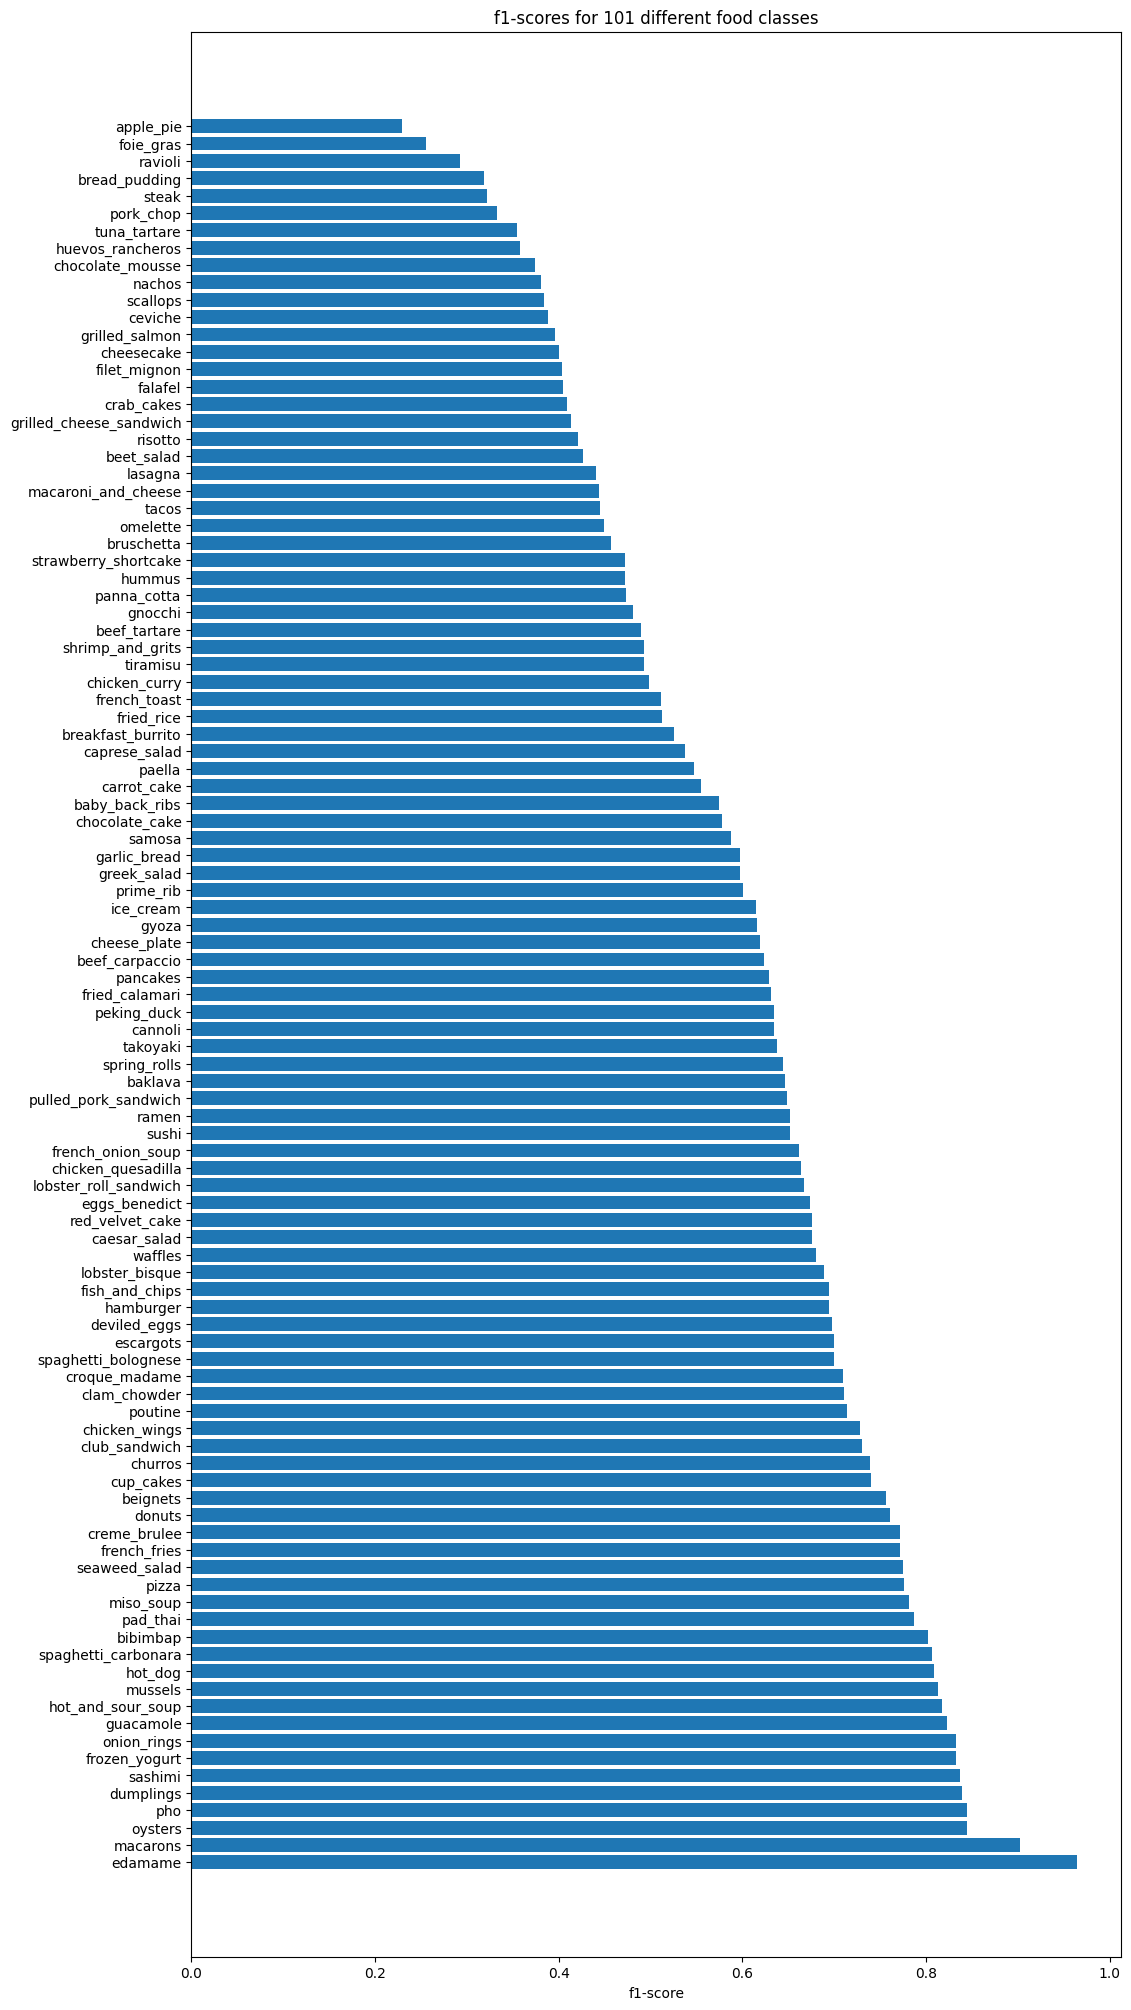

In [48]:
import matplotlib.pyplot as plt 

fig , ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1-score")
ax.set_title("f1-scores for 101 different food classes")

## Visualizing predictions on custom images
Now, this is the real test, how does our model go on food images not even in our test dataset(images of our own).

In [49]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:   
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 27ms/step


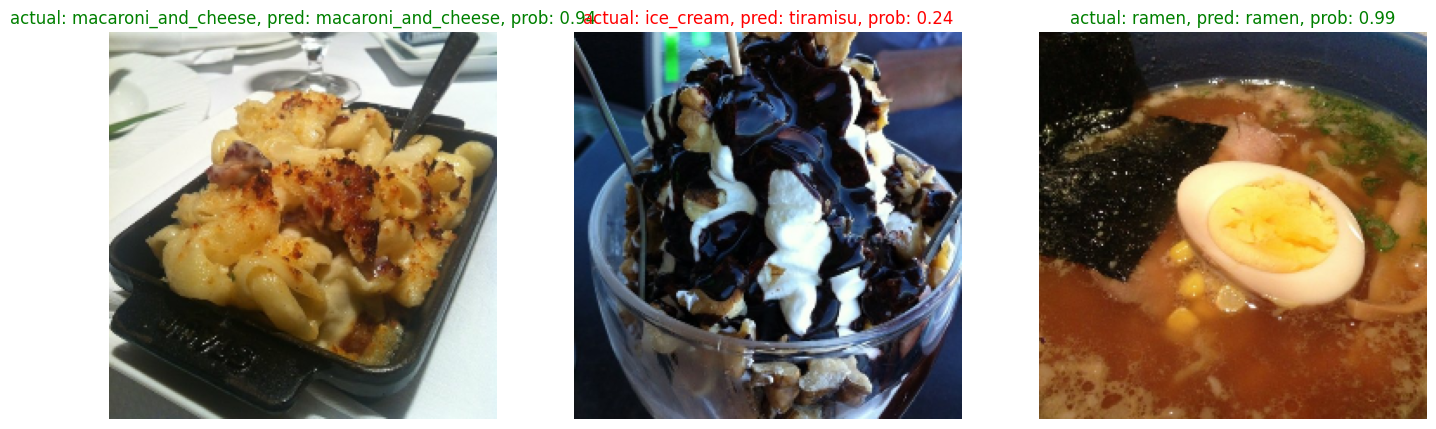

In [50]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: 
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [52]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [53]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,28,0.191825,apple_pie,croque_madame
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.885502,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.400135,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.314893,apple_pie,bread_pudding
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,8,0.535095,apple_pie,bread_pudding


In [54]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

KeyError: ignored